# AML Challenge

## Setup

In [48]:
# Loading libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from datetime import datetime

In [39]:
# Loading data
account = pd.read_csv('Data/account.csv', sep = ';')
card = pd.read_csv('Data/card.csv', sep = ';')
client = pd.read_csv('Data/client.csv', sep = ';')
disp = pd.read_csv('Data/disp.csv', sep = ';')
district = pd.read_csv('Data/district.csv', sep = ';')
loan = pd.read_csv('Data/loan.csv', sep = ';')
order = pd.read_csv('Data/order.csv', sep = ';')
trans = pd.read_csv('Data/trans.csv', sep = ';')

C:\Users\chant\AppData\Local\Temp/ipykernel_16032/1677394057.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv('Data/trans.csv', sep = ';')


## Explorative Data Analysis

### Account
Data wrangling with the csv account. Here's a brief description from the website: 

In [40]:
print(account.head())

   account_id  district_id         frequency    date
0         576           55  POPLATEK MESICNE  930101
1        3818           74  POPLATEK MESICNE  930101
2         704           55  POPLATEK MESICNE  930101
3        2378           16  POPLATEK MESICNE  930101
4        2632           24  POPLATEK MESICNE  930102


It seems that the date column is wrong, let's fix that. 

In [41]:
# Fixing the date column
account['date'] = pd.to_datetime(account['date'], format='%y%m%d')
print(account.head())

   account_id  district_id         frequency       date
0         576           55  POPLATEK MESICNE 1993-01-01
1        3818           74  POPLATEK MESICNE 1993-01-01
2         704           55  POPLATEK MESICNE 1993-01-01
3        2378           16  POPLATEK MESICNE 1993-01-01
4        2632           24  POPLATEK MESICNE 1993-01-02


# Hier weiter

In [42]:
# Translating the frequency into English


In [43]:
print(account.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   account_id   4500 non-null   int64         
 1   district_id  4500 non-null   int64         
 2   frequency    4500 non-null   object        
 3   date         4500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 140.8+ KB
None


In [44]:
# Checking if there are any data missing
print(account.isnull().sum())

account_id     0
district_id    0
frequency      0
date           0
dtype: int64


In [45]:
print(account['account_id'].nunique())
print(account['district_id'].nunique())

4500
77


#### Summary EDA Account

There are 4500 unique clients in 77 districs. 

### Client

In [46]:
print(client.head)

<bound method NDFrame.head of       client_id  birth_number  district_id
0             1        706213           18
1             2        450204            1
2             3        406009            1
3             4        561201            5
4             5        605703            5
...         ...           ...          ...
5364      13955        456030            1
5365      13956        430406            1
5366      13968        680413           61
5367      13971        626019           67
5368      13998        535812           74

[5369 rows x 3 columns]>


In [47]:
# Function to calculate the birthday, gender and age from birth_number
def calculate_birthday(df):
    
    genders = []
    birthdays = []
    ages = []
    
    base_date = datetime(1999, 12, 31)
    
    for birth_number in df['birth_number']:
        birth_number_str = str(birth_number)
        
        year = int("19" + birth_number_str[:2])
        month = int(birth_number_str[2:4])
        day = int(birth_number_str[4:6])
        
        if month > 12:
            gender = "female"
            month -= 50  # minus 50 for females
        else:
            gender = "male"
        
        birth_day = datetime(year, month, day)
        age = base_date.year - birth_day.year - ((base_date.month, base_date.day) < (birth_day.month, birth_day.day))
        
        genders.append(gender)
        birthdays.append(birth_day)
        ages.append(age)
    
    df['gender'] = genders
    df['birth_day'] = birthdays
    df['age'] = ages
    
    df = df.drop(columns=['birth_number'])
    
    return df

client = calculate_birthday(client)
#client.head

<bound method NDFrame.head of       client_id  district_id  gender  birth_day  age
0             1           18  female 1970-12-13   29
1             2            1    male 1945-02-04   54
2             3            1  female 1940-10-09   59
3             4            5    male 1956-12-01   43
4             5            5  female 1960-07-03   39
...         ...          ...     ...        ...  ...
5364      13955            1  female 1945-10-30   54
5365      13956            1    male 1943-04-06   56
5366      13968           61    male 1968-04-13   31
5367      13971           67  female 1962-10-19   37
5368      13998           74  female 1953-08-12   46

[5369 rows x 5 columns]>

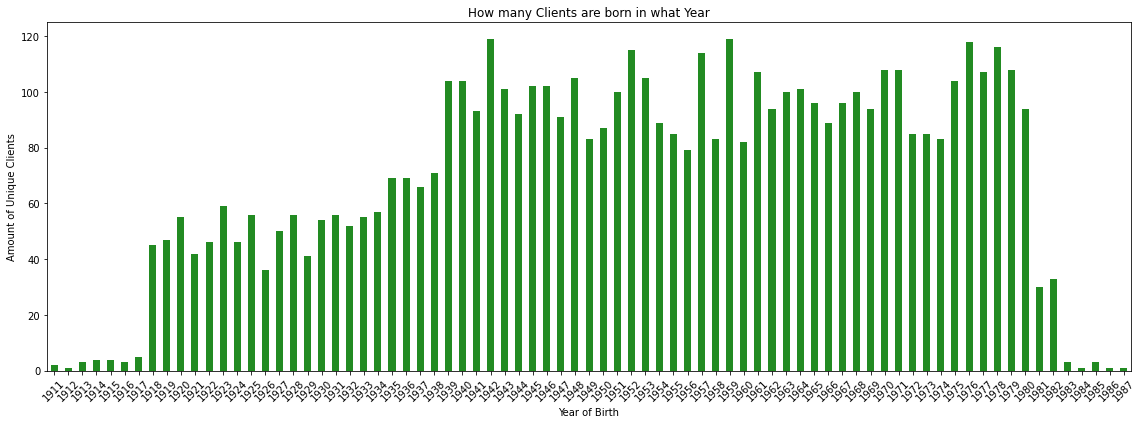

In [50]:
client['birth_year'] = pd.to_datetime(client['birth_day']).dt.year
client_count_per_year = client.groupby('birth_year')['client_id'].nunique()

# Plot
plt.figure(figsize=(16, 6))
client_count_per_year.plot(kind='bar', color='forestgreen')
plt.title('How many Clients are born in what Year')
plt.xlabel('Year of Birth')
plt.ylabel('Amount of Unique Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()